# Exercise 1: Clustering
**Goal:** Implement the clustering algorithm called Bisecting k-Means.

Bisecting k-Means is a clustering algorithm that combines hierarchical clustering with k-Means. However, differently than the hierarchical clustering we saw in the lecture, it uses a divisive, top-down approach (instead of the agglomerative, bottom-up that we are used to). It consists on the steps described below:  
1. Start with a single cluster including all the observations in the data set.
2. [Bisecting] Divide the largest cluster into two smaller sub-clusters using k-Means.
3. Redo the bisecting step iter times and choose the best solution according to the Sum of Squared Errors (SSE).
4. Repeat from Step 2 until you have k clusters.

Implement the Bisecting k-Means algorithm in a function called bkmeans. It should take as input: (a) the data X to cluster, as a n×pmatrix (nobservations by pfeatures); (b) the number k of clusters; and (c) the number iter of iterations for step 3. It should generate as output a n×1 vector with the cluster indices for each of the n observations.

**Notes:**  
1. You must implement K-Means yourself, from scratch.
2. The requirements are strict. I will use standard test cases in order to test your solution by calling the function
bkmeans as described.

In [32]:
import numpy as np


def kmeans(X, num_clusters, max_iters=100):
    """Performs k-means clustering on the dataset X."""
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, num_clusters, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = []
        for i in range(num_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                new_centroids.append(X[np.random.choice(n_samples)])
        new_centroids = np.array(new_centroids)

        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids


def calculate_sse(X, labels, centroids):
    """Calculates the Sum of Squared Errors (SSE) for the given clustering."""
    sse = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[labels == i]
        sse += np.sum((cluster_points - centroid) ** 2)
    return sse


def bkmeans(X, k, iter):
    """Implements the Bisecting k-Means clustering algorithm."""
    clusters = [X]
    while len(clusters) < k:
        largest_cluster_index = np.argmax([len(cluster) for cluster in clusters])
        largest_cluster = clusters.pop(largest_cluster_index)

        best_sse = float("inf")
        best_labels = None

        for _ in range(iter):
            labels, centroids = kmeans(largest_cluster, 2)
            sse = calculate_sse(largest_cluster, labels, centroids)
            if sse < best_sse:
                best_sse = sse
                best_labels = labels

        cluster_1 = largest_cluster[best_labels == 0]
        cluster_2 = largest_cluster[best_labels == 1]

        clusters.append(cluster_1)
        clusters.append(cluster_2)

    final_labels = np.zeros(X.shape[0], dtype=int)
    for cluster_index, cluster in enumerate(clusters):
        for point in cluster:
            point_index = np.where((X == point).all(axis=1))[0][0]
            final_labels[point_index] = cluster_index

    return final_labels

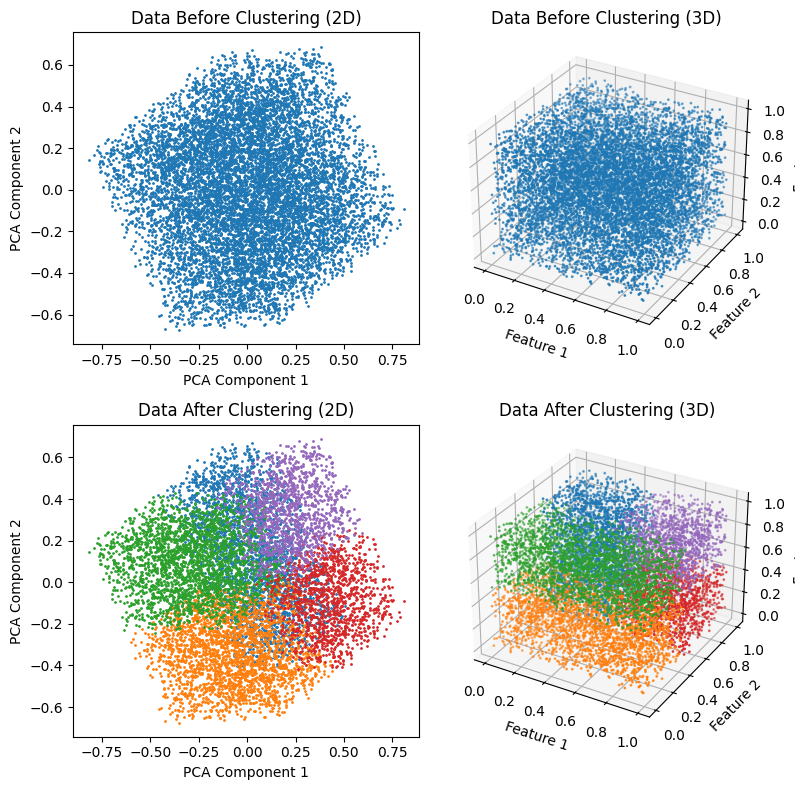

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = np.random.rand(10000, 3)
k = 5
iter = 10

# Visualize data before clustering in 2D
pca_2d = PCA(n_components=2)
X_reduced_2d = pca_2d.fit_transform(X)
plt.figure(figsize=(8, 8))  # Adjusted to make the plot square
plt.subplot(2, 2, 1)
plt.scatter(X_reduced_2d[:, 0], X_reduced_2d[:, 1], s=1)
plt.title("Data Before Clustering (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Visualize data before clustering in 3D
ax = plt.subplot(2, 2, 2, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1)
ax.set_title("Data Before Clustering (3D)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")

final_labels = bkmeans(X, k, iter)

# Visualize data after clustering in 2D
plt.subplot(2, 2, 3)
for label in np.unique(final_labels):
    cluster_points = X_reduced_2d[final_labels == label]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1], s=1, label=f"Cluster {label}"
    )
plt.title("Data After Clustering (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Visualize data after clustering in 3D
ax = plt.subplot(2, 2, 4, projection="3d")
for label in np.unique(final_labels):
    cluster_points = X[final_labels == label]
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        cluster_points[:, 2],
        s=1,
        label=f"Cluster {label}",
    )
ax.set_title("Data After Clustering (3D)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")

plt.tight_layout()
plt.show()

# Exercise 2: Visualization of Results

In this exercise, I initially intended to select 3 datasets for exploration through dimensionality reduction. However, while experimenting with over 10 datasets, I was "lucky" to learn about the curse of dimensionality. It appeared to be challenging to find a dataset suitable for meaningful visualization in two or three dimensions. 

Thus, I decided to pick 8 datasets. Some of these datasets required preprocessing to be suitable for analysis. The preprocessing techniques I employed included:
- One-hot encoding for categorical features
- Normalization to a standard distribution
- Mean imputation for handling missing values

Additionally, for computational efficiency, I limited the parsing to a maximum of 2,000 random data points from each dataset. Boolean values were also converted to their numerical equivalents.

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.io import arff

def load_csv_dataset(file_path, header=0):
    """Load a dataset from a given file path."""
    return pd.read_csv(file_path, header=header)

def load_arff_dataset(file_path):
    """Load a dataset from an ARFF file."""
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)

    for column in df.select_dtypes([object]):
        df[column] = df[column].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
        if df[column].str.isnumeric().all():
            df[column] = pd.to_numeric(df[column])

    return df

def preprocess_features(data, normalize=False, impute=False, feature_range=None):
    """Preprocess the dataset by optionally normalizing and imputing missing values."""
    features = data.iloc[:, feature_range[0]:feature_range[1]] if feature_range else data.iloc[:, :-1]
    if impute:
        features.fillna(features.mean(), inplace=True)
    if normalize:
        features = StandardScaler().fit_transform(features)
    return features

def one_hot_encode_columns(data, columns):
    """One-hot encodes specified columns in a dataset."""
    encoded_columns = [pd.get_dummies(data[col], prefix=col) for col in columns]
    data = data.drop(columns, axis=1)
    data = pd.concat([data] + encoded_columns, axis=1)
    return data

def map_grades(score):
    """Map numerical scores to letter grades."""
    return 'VG' if score >= 80 else 'G' if score >= 50 else 'F'

def map_avocado_labels(label):
    """Map numerical avocado labels to categorical labels."""
    if 0.25 <= label < 0.5:
        return 'CL0'
    elif 0.5 <= label < 0.75:
        return 'CL1'
    elif 0.75 <= label < 1.0:
        return 'CL2'
    elif 1.0 <= label < 1.25:
        return 'CL3'
    elif 1.25 <= label < 1.5:
        return 'CL4'
    elif 1.5 <= label < 1.75:
        return 'CL5'
    elif 1.75 <= label < 2.0:
        return 'CL6'
    elif 2.0 <= label < 2.25:
        return 'CL7'
    elif 2.25 <= label < 2.5:
        return 'CL8'
    elif 2.5 <= label < 2.75:
        return 'CL9'
    elif 2.75 <= label < 3.0:
        return 'CL10'
    elif 3.0 <= label <= 3.25:
        return 'CL11'
    else:
        return 'Unknown'
    
# Some datasets are too big. We will randomly sample 2000 instances from each dataset.
np.random.seed(1945)
num_samples = 2000

red_wine_data = load_csv_dataset('./resources/datasets/red_wine_quality.csv')
red_wine_features = preprocess_features(red_wine_data, normalize=True)
red_wine_labels = red_wine_data.iloc[:, -1].values

water_potability_data = load_csv_dataset('./resources/datasets/water_potability.csv')
r_indices = np.random.choice(water_potability_data.index, num_samples, replace=False)
water_potability_data = water_potability_data.loc[r_indices]
water_potability_features = preprocess_features(water_potability_data, normalize=True, impute=True)
water_potability_labels = water_potability_data.iloc[:, -1].values

student_performance_data = load_csv_dataset('./resources/datasets/student_performance.csv')
r_indices = np.random.choice(student_performance_data.index, num_samples, replace=False)
student_performance_data = student_performance_data.loc[r_indices]
student_performance_data['Extracurricular Activities'] = student_performance_data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
student_performance_data['Performance Index'] = student_performance_data['Performance Index'].apply(map_grades)
student_performance_features = preprocess_features(student_performance_data, normalize=True)
student_performance_labels = student_performance_data['Performance Index'].values

avocado_data = load_csv_dataset('./resources/datasets/avocado.csv')
avocado_data = one_hot_encode_columns(avocado_data, ['type'])
avocado_data = avocado_data.drop('region', axis=1)
r_indices = np.random.choice(avocado_data.index, num_samples, replace=False)
avocado_data = avocado_data.loc[r_indices]
avocado_features = preprocess_features(avocado_data, normalize=True, feature_range=(3, None))
avocado_labels = avocado_data.iloc[:, 2].apply(map_avocado_labels)

mobile_price_data = load_csv_dataset('./resources/datasets/mobile_price.csv')
mobile_price_features = preprocess_features(mobile_price_data, normalize=True)
mobile_price_labels = mobile_price_data.iloc[:, -1].values

games_data = load_csv_dataset('./resources/datasets/games.csv', header=0).drop(columns=['app_id', 'title', 'date_release', 'win', 'steam_deck'])
games_data['mac'] = games_data['mac'].apply(lambda x: 1 if str(x).lower() == 'true' else 0)
games_data['linux'] = games_data['linux'].apply(lambda x: 1 if str(x).lower() == 'true' else 0)
r_indices = np.random.choice(games_data.index, 2000, replace=False)
games_data = games_data.loc[r_indices]
games_labels = games_data['rating'].values
games_features = preprocess_features(games_data.drop(columns=['rating']), normalize=True)

dry_bean_data = load_arff_dataset('./resources/datasets/dry_bean_dataset.arff')
r_indices = np.random.choice(dry_bean_data.index, 2000, replace=False)
dry_bean_data = dry_bean_data.loc[r_indices]
dry_bean_features = preprocess_features(dry_bean_data, normalize=True)
dry_bean_labels = dry_bean_data.iloc[:, -1].values

crop_recommendation_data = load_csv_dataset('./resources/datasets/Crop_Recommendation.csv', header=0)
crop_recommendation_features = preprocess_features(crop_recommendation_data, normalize=True)
crop_recommendation_labels = crop_recommendation_data.iloc[:, -1].values


datasets = [
    (red_wine_features, red_wine_labels, 'Red Wine Quality'),
    (water_potability_features, water_potability_labels, 'Water Potability'),
    (student_performance_features, student_performance_labels, 'Student Performance'),
    (avocado_features, avocado_labels, 'Avocado Prices'),
    (mobile_price_features, mobile_price_labels, 'Mobile Phone Prices'),
    (games_features, games_labels, 'Games Reviews'),
    (dry_bean_features, dry_bean_labels, 'Dry Bean Classification'),
    (crop_recommendation_features, crop_recommendation_labels, 'Crop Recommendation')
]

## Exercise 2.1: Comparison of DR Techniques

In this exercise, I applied dimensionality reduction to all eight datasets and used the silhouette score to identify the three datasets with the highest class separation. The following cell calculates silhouette scores for datasets reduced to 2 and 3 dimensions, then displays the dimension with the superior silhouette scores. It also prints the mean silhouette scores after the plots.

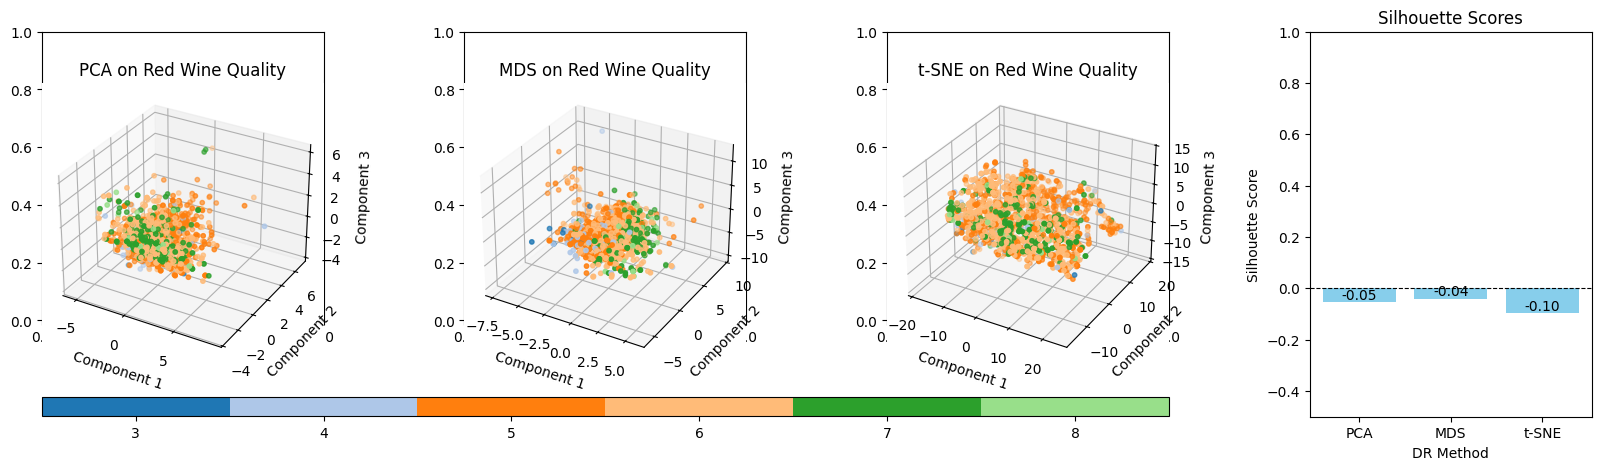

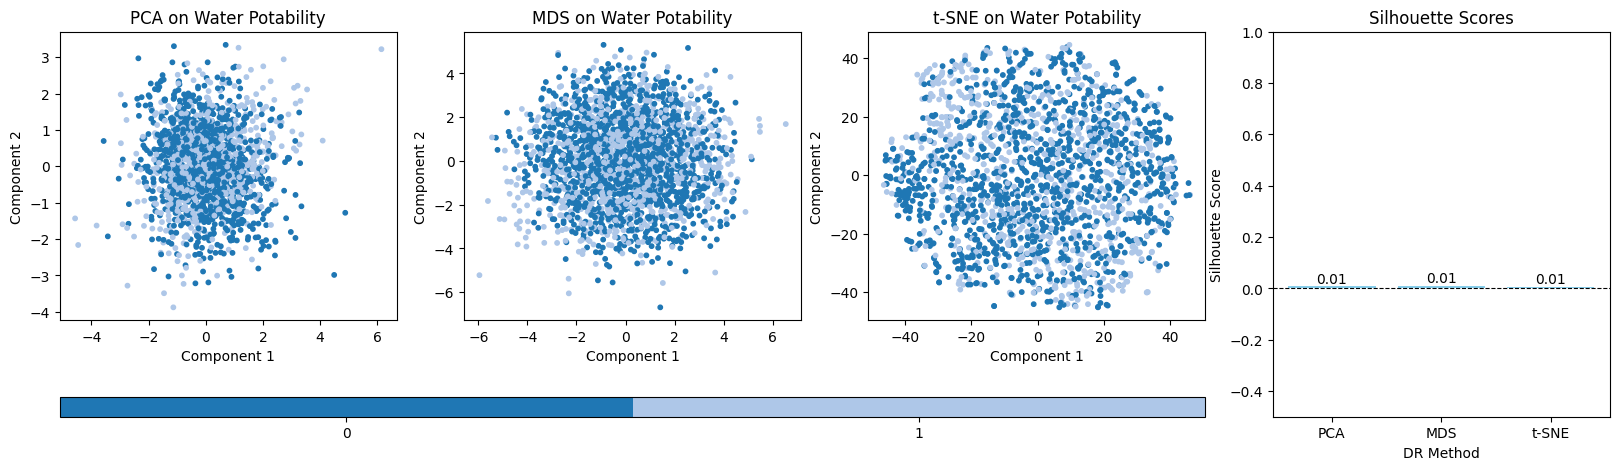

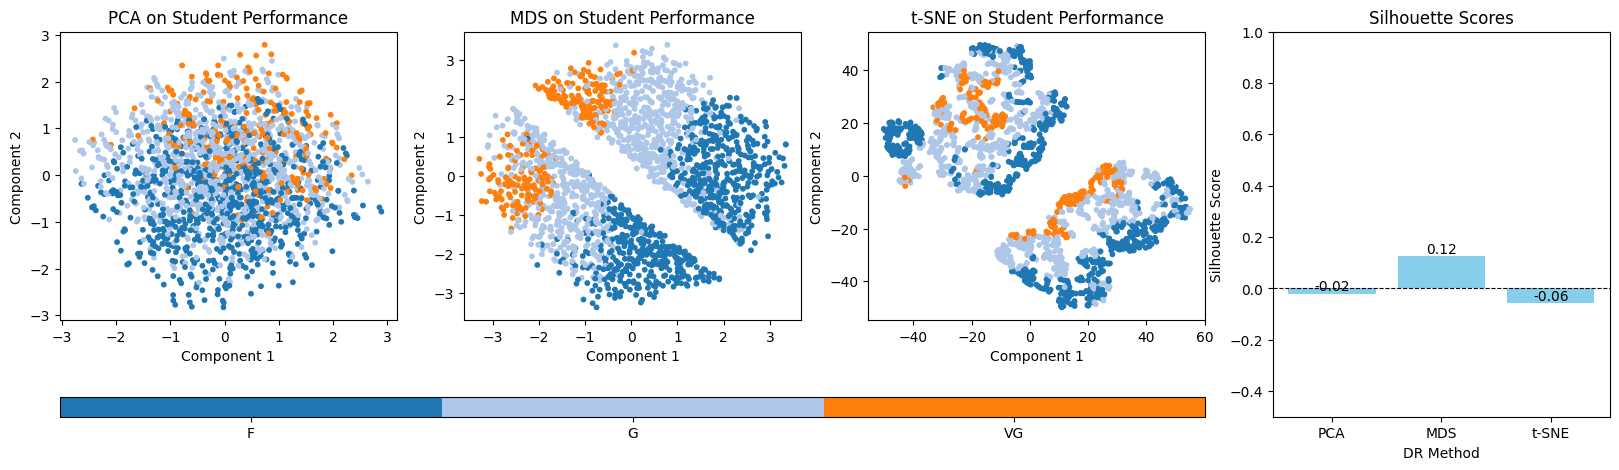

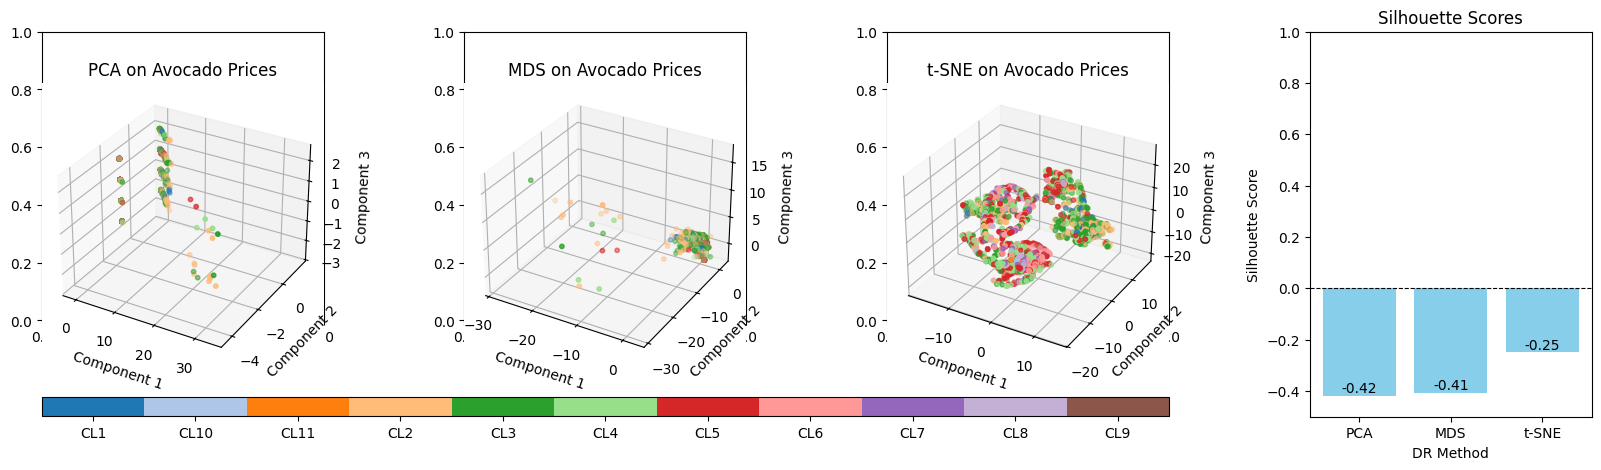

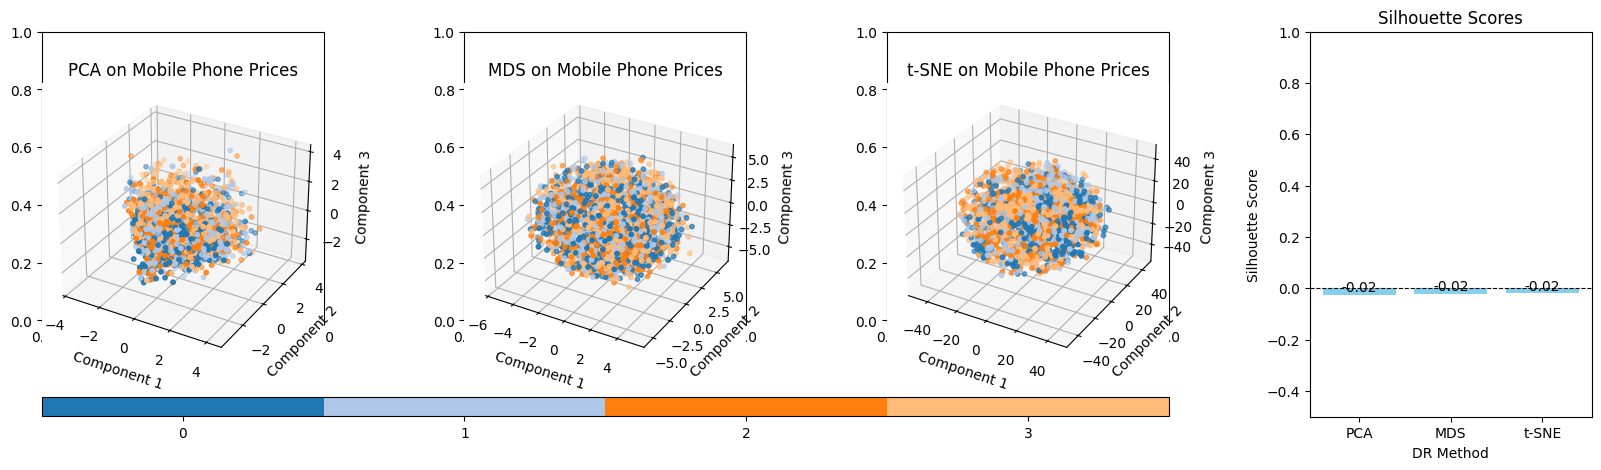

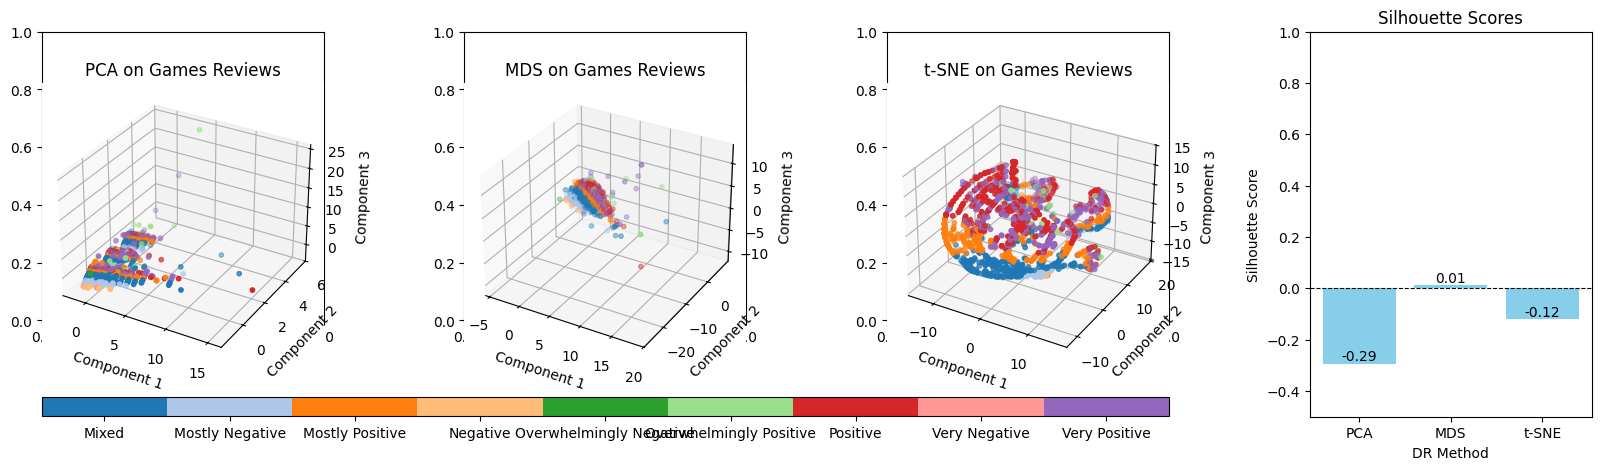

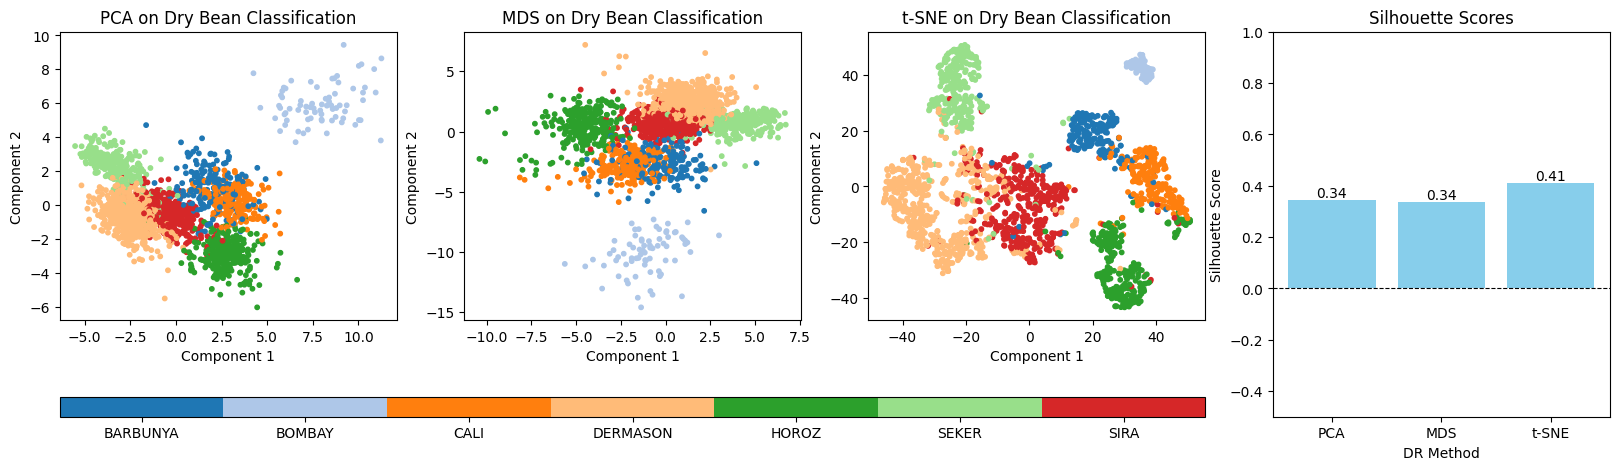

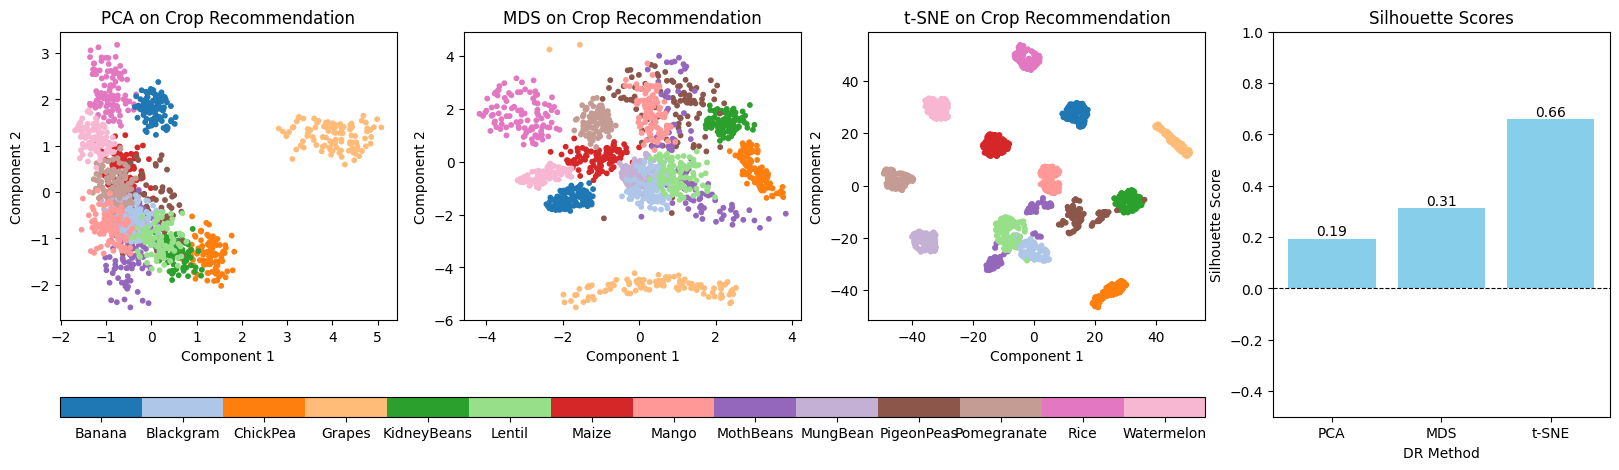

Mean silhouette score for each DR method:
PCA     -0.033089
MDS      0.041187
t-SNE    0.066804


In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import silhouette_score


def perform_dimensionality_reduction(data, fast=False):
    """Perform dimensionality reduction on the given dataset using PCA, MDS, and t-SNE."""
    def get_dr_methods(n_components, fast):
        if fast:
            return [
                PCA(n_components=n_components, svd_solver="randomized", tol=1e-2),
                MDS(n_components=n_components, n_init=1, max_iter=100, eps=1e-2),
                TSNE(n_components=n_components, perplexity=5, learning_rate=200, max_iter=250),
            ]
        else:
            return [
                PCA(n_components=n_components, svd_solver="full", tol=1e-4),
                MDS(n_components=n_components, n_init=5, max_iter=300, eps=1e-4),
                TSNE(n_components=n_components, perplexity=30, learning_rate="auto", max_iter=1000),
            ]

    dr_methods_3d = get_dr_methods(3, fast)
    dr_methods_2d = get_dr_methods(2, fast)

    transformed_data_3d_list = np.array([dr_method.fit_transform(data) for dr_method in dr_methods_3d])
    transformed_data_2d_list = np.array([dr_method.fit_transform(data) for dr_method in dr_methods_2d])

    return transformed_data_3d_list, transformed_data_2d_list


def calculate_silhouette_scores(data_3d, data_2d, labels):
    """Calculate silhouette scores for 3D and 2D data."""
    numerical_labels = np.unique(labels, return_inverse=True)[1]
    scores_3d = [
        silhouette_score(transformed_data, numerical_labels)
        for transformed_data in data_3d
    ]
    scores_2d = [
        silhouette_score(transformed_data, numerical_labels)
        for transformed_data in data_2d
    ]
    return scores_3d, scores_2d


def plot_dr_techniques(data, silhouette_scores, labels, title, projection="3D"):
    """Visualize data after dimensionality reduction with silhouette scores."""
    dr_names = ["PCA", "MDS", "t-SNE"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    unique_labels, numerical_labels = np.unique(labels, return_inverse=True)
    num_unique_labels = len(unique_labels)
    cmap = ListedColormap(plt.cm.tab20.colors[:num_unique_labels])

    for i, (ax, transformed_data, dr_name, score) in enumerate(
        zip(axes[:3], data, dr_names, silhouette_scores)
    ):
        if projection.upper() == "3D":
            ax = fig.add_subplot(1, 4, i + 1, projection="3d")
            scatter = ax.scatter(
                transformed_data[:, 0],
                transformed_data[:, 1],
                transformed_data[:, 2],
                c=numerical_labels,
                cmap=cmap,
                s=10,
            )
            ax.set_zlabel("Component 3")
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
        elif projection.upper() == "2D":
            scatter = ax.scatter(
                transformed_data[:, 0],
                transformed_data[:, 1],
                c=numerical_labels,
                cmap=cmap,
                s=10,
            )
        else:
            raise ValueError("Projection must be either 3D or 2D.")

        ax.set_title(f"{dr_name} on {title}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")

    axes[3].bar(dr_names, silhouette_scores, color="skyblue")
    axes[3].set_title("Silhouette Scores")
    axes[3].set_xlabel("DR Method")
    axes[3].set_ylabel("Silhouette Score")
    axes[3].set_ylim(-0.5, 1)
    axes[3].axhline(y=0, color="black", linestyle="--", linewidth=0.8)

    for bar, score in zip(axes[3].patches, silhouette_scores):
        axes[3].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{score:.2f}",
            ha="center",
            va="bottom",
        )

    boundaries = np.arange(min(numerical_labels) - 0.5, max(numerical_labels) + 1.5)
    cbar = fig.colorbar(
        scatter,
        ax=axes[:3],
        orientation="horizontal",
        fraction=0.05,
        pad=0.2,
        boundaries=boundaries,
        aspect=60,
    )
    cbar.set_ticks(np.arange(num_unique_labels))
    cbar.set_ticklabels(unique_labels)
    plt.show()

best_scores = pd.DataFrame(columns=["PCA", "MDS", "t-SNE"])

for data, labels, title in datasets:
    data_3d, data_2d = perform_dimensionality_reduction(data, fast=False)
    scores_3d, scores_2d = calculate_silhouette_scores(data_3d, data_2d, labels)

    if max(scores_3d) > max(scores_2d):
        plot_dr_techniques(data_3d, scores_3d, labels, title, projection="3D")
        best_scores.loc[len(best_scores)] = scores_3d
    else:
        plot_dr_techniques(data_2d, scores_2d, labels, title, projection="2D")
        best_scores.loc[len(best_scores)] = scores_2d

mean_scores = best_scores.mean()
print("Mean silhouette score for each DR method:")
print(mean_scores.to_string())

### Discussion
First of all, out of the 8 datasets, only 2 provided meaningful visualizations after dimensionality reduction. One of these datasets managed to find a weak separation for the student performance dataset, while the other 5 datasets resulted in visualizations that were essentially noise.

In 4 datasets, all three dimensionality reduction methods performed similarly. However, in the other 4 datasets, there were noticeable differences for at least one of the three methods, particularly MDS or t-SNE. Although it's challenging to draw definitive conclusions without deeper analysis, both the silhouette score graphs and the mean silhouette scores for each method indicate that t-SNE demonstrates the best performance among the three methods.

Now, let's discuss class separation. In the least effective 5 datasets, we observe just noise. However, in the other 3 datasets, namely student performance, dry bean, and crop recommendation datasets, we can notice some patterns:
- The VG and F classes mix with the G class, but not with each other. This makes sense because these classes are sequential, with F representing scores of less than 50, G representing scores between 50 and 80, and VG representing scores above 80. It is logical that there is minimal overlap between the metrics of the worst and best performers, with some overlap with the "medium" category.
- The CALY and BARBUNYA dry bean classes exhibit poor class separability when using PCA and MDS techniques, but show a much better separation with t-SNE. The SIRA class appears to be positioned in the "middle" of all other classes, indicating that it shares characteristics with multiple classes.
- For the crop recommendation dataset, t-SNE dimensionality reduction offers excellent separation between all classes, although some outliers in several classes mix into neighboring classes, significantly reducing the silhouette score despite a visually sound separation. For each dimensionality reduction technique, most crops tend to mix with the same 2-3 neighboring classes. Notably, the "Grapes" class is the only one that is fully separated from others across all three dimensionality reduction techniques.

### Conclusion
The analysis suggests that t-SNE generally outperforms other dimensionality reduction methods in terms of class separation. However, the effectiveness of these methods can vary significantly depending on the dataset. A deeper analysis is needed to draw additional conclusions.

## Exercise 2.2 Comparison of Clustering Techniques
Choose one of the DR techniques from the previous exercise and generate a similar scatterplot matrix to compare the results of Bisecting k-Means with classic k-Means and hierarchical clustering for each data set. The resulting visualization should be a 3×3 matrix where each cell is a scatterplot of the chosen DR technique applied to a data set, with the colors of the points showing the clusters using a qualitative colormap (see, e.g., https://matplotlib.org/tutorials/colors/colormaps.html).

Then answer this shortly (in a couple of paragraphs): In your opinion, which clustering technique performed the best for each data set? How are the clusters in the data sets separated? Are some clusters easier to separate than others?

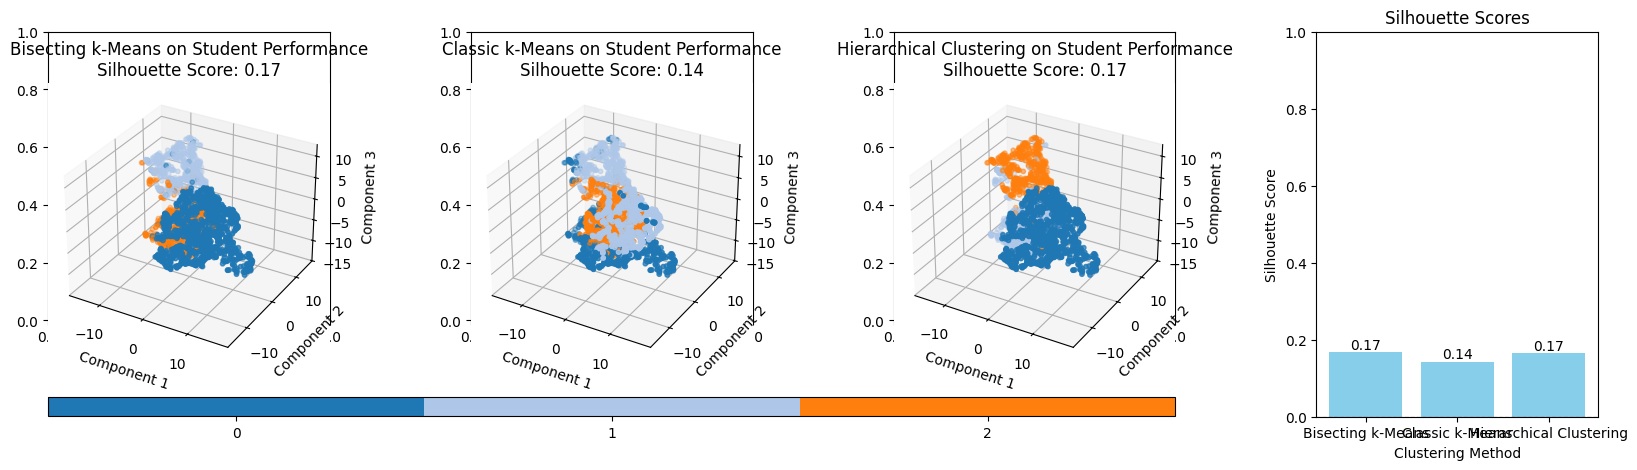

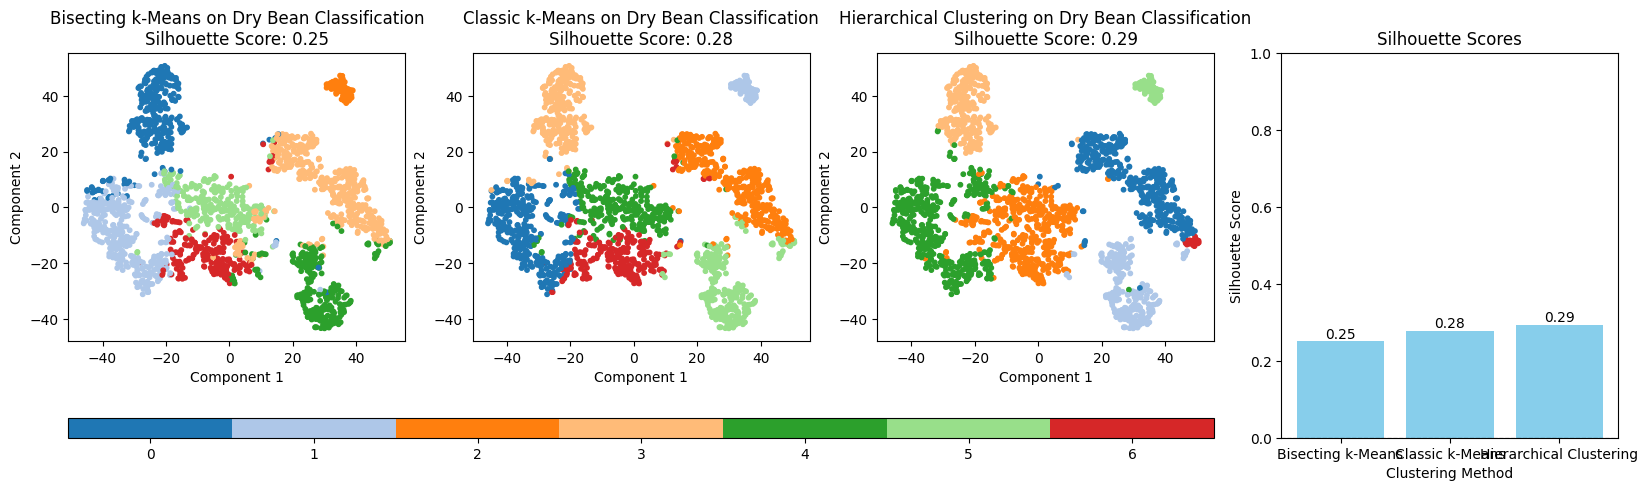

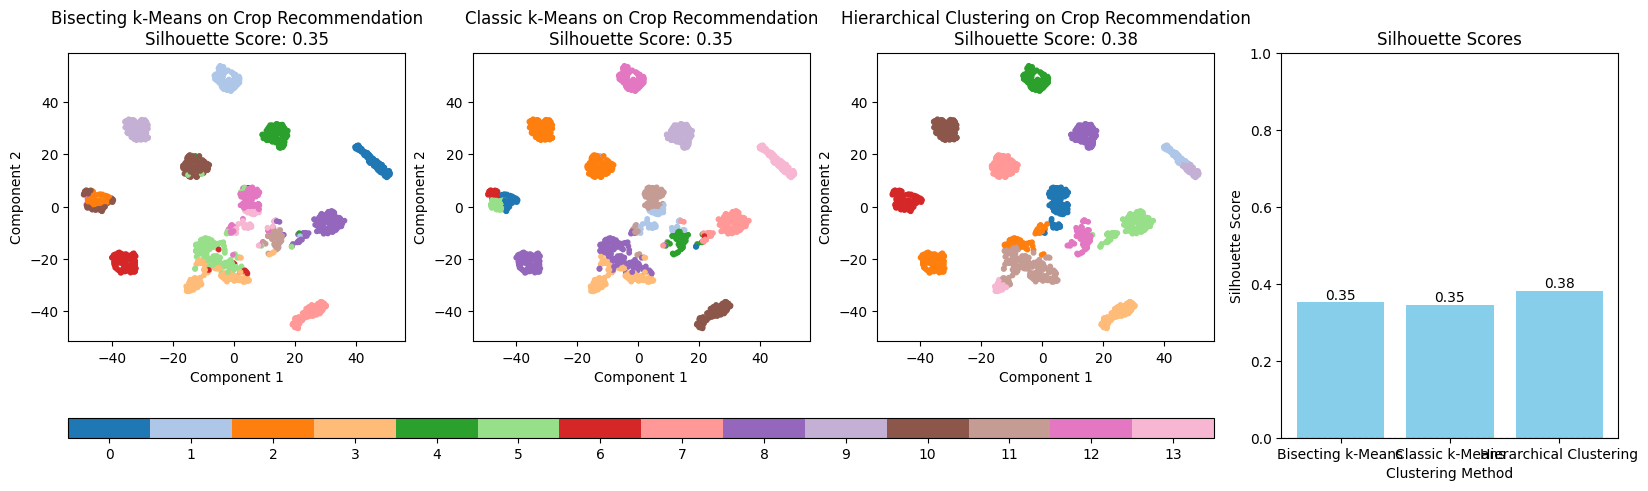

In [51]:
from sklearn.cluster import AgglomerativeClustering


def plot_clustering_comparison(data, labels, title, projection=None):
    """Plot the clustering results for different methods and display silhouette scores."""

    if projection == "3D":
        dr_method = TSNE(
            n_components=3,
            perplexity=30,
            learning_rate='auto',
            max_iter=1000,
        )
    elif projection == "2D":
        dr_method = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate='auto',
            max_iter=1000,
        )
    else:
        raise ValueError("Projection must be either 3D or 2D.")
    
    fig, axes = plt.subplots(
        1, 4, figsize=(20, 5)
    )

    clustering_methods = [
        ("Bisecting k-Means", bkmeans),
        ("Classic k-Means", kmeans),
        ("Hierarchical Clustering", AgglomerativeClustering),
    ]

    transformed_data = dr_method.fit_transform(data)

    num_clusters = len(np.unique(labels))
    silhouette_scores = []

    for i, (clustering_name, clustering_func) in enumerate(clustering_methods):
        if clustering_name == "Hierarchical Clustering":
            model = clustering_func(n_clusters=num_clusters)
            cluster_labels = model.fit_predict(data)
        elif clustering_name == "Bisecting k-Means":
            cluster_labels = clustering_func(data, k=num_clusters, iter=100)
        else:
            cluster_labels, _ = clustering_func(data, num_clusters=num_clusters)

        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        unique_labels, numerical_labels = np.unique(labels, return_inverse=True)
        num_unique_labels = len(unique_labels)
        cmap = ListedColormap(plt.cm.tab20.colors[:num_unique_labels])

        ax = axes[i]
        if projection.upper() == "2D":
            scatter = ax.scatter(
                transformed_data[:, 0],
                transformed_data[:, 1],
                c=cluster_labels,
                cmap=cmap,
                s=10,
            )
            ax.set_xlabel("Component 1")
            ax.set_ylabel("Component 2")
        elif projection.upper() == "3D":
            ax = fig.add_subplot(1, 4, i + 1, projection='3d')
            scatter = ax.scatter(
                transformed_data[:, 0],
                transformed_data[:, 1],
                transformed_data[:, 2],
                c=cluster_labels,
                cmap=cmap,
                s=10,
            )
            ax.set_xlabel("Component 1")
            ax.set_ylabel("Component 2")
            ax.set_zlabel("Component 3")
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
        ax.set_title(
            f"{clustering_name} on {title}\nSilhouette Score: {silhouette_avg:.2f}"
        )

    axes[3].bar([method[0] for method in clustering_methods], silhouette_scores, color="skyblue")
    axes[3].set_title("Silhouette Scores")
    axes[3].set_xlabel("Clustering Method")
    axes[3].set_ylabel("Silhouette Score")
    axes[3].set_ylim(0, 1)
    axes[3].axhline(y=0, color="black", linestyle="--", linewidth=0.8)

    for bar, score in zip(axes[3].patches, silhouette_scores):
        axes[3].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{score:.2f}",
            ha="center",
            va="bottom",
        )

    boundaries = np.arange(min(numerical_labels) - 0.5, max(numerical_labels) + 1.5)
    cbar = fig.colorbar(
        scatter,
        ax=axes[:3],
        orientation="horizontal",
        fraction=0.05,
        pad=0.2,
        boundaries=boundaries,
        aspect=60,
    )
    cbar.set_ticks(np.arange(num_unique_labels))
    plt.show()

data, labels, title = datasets[2]
plot_clustering_comparison(data, labels, title, projection="3D")

data, labels, title = datasets[6]
plot_clustering_comparison(data, labels, title, projection="2D")

data, labels, title = datasets[7]
plot_clustering_comparison(data, labels, title, projection="2D")


### Discussion

The silhouette scores graphs show that all three clustering techniques produce similar cluster separations. The differences are minimal and can be attributed to randomness, making it difficult to compare performance of the clustering techniques on these three datasets.

For the dry beans and crop recommendation datasets, the resulting clusters closely match the original clusters, suggesting that all three techniques successfully identified the underlying patterns in the data. However, in the student performance dataset, the cluster shapes differ significantly, with all three categories overlapping. This indicates that none of the clustering techniques effectively captured the linearity of the original classes.